# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-6` or less.

In [4]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  6.335163002532046e-10
dh error:  3.3963774090592634e-10
dc error:  1.5221723979041107e-10
dWx error:  2.1010960934639614e-09
dWh error:  9.712296109943072e-08
db error:  2.491522041931035e-10


# LSTM: forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error around `1e-7`.

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-7` or less.

In [6]:
from cs231n.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  6.9939005453315376e-09
dh0 error:  1.5042746972106784e-09
dWx error:  3.226295800444722e-09
dWh error:  2.6984653167426663e-06
db error:  8.23662763415198e-10


# LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.824459354432264
expected loss:  9.82445935443
difference:  2.2648549702353193e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see losses less than 0.5.

(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829101
(Iteration 21 / 100) loss: 30.062625
(Iteration 31 / 100) loss: 14.020167
(Iteration 41 / 100) loss: 6.004904
(Iteration 51 / 100) loss: 1.851745
(Iteration 61 / 100) loss: 0.638921
(Iteration 71 / 100) loss: 0.286683
(Iteration 81 / 100) loss: 0.236246
(Iteration 91 / 100) loss: 0.124038


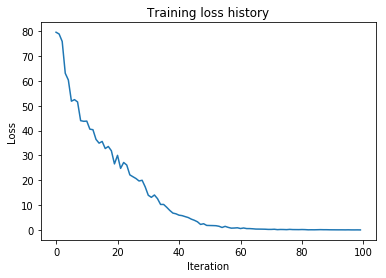

In [8]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples.

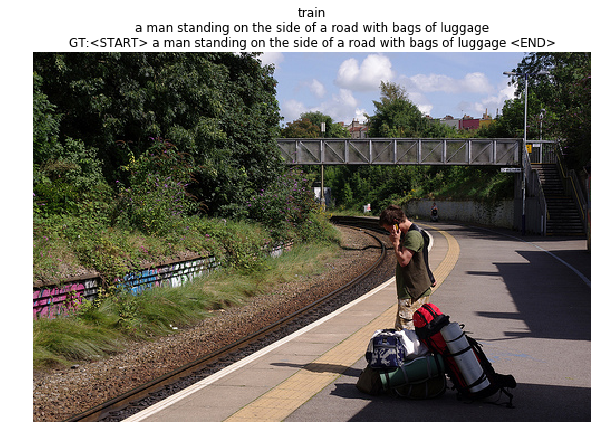

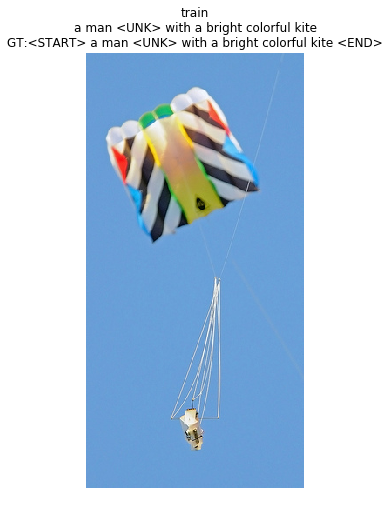

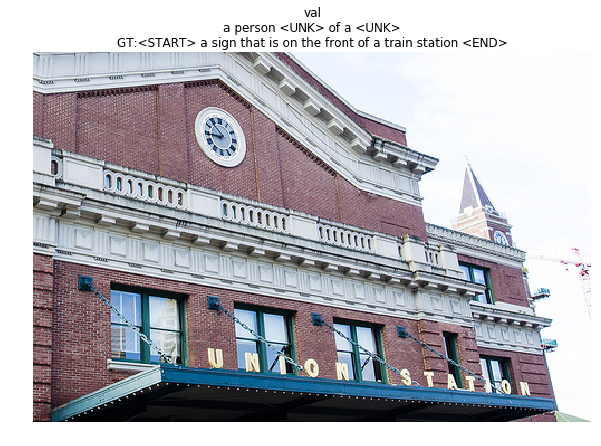

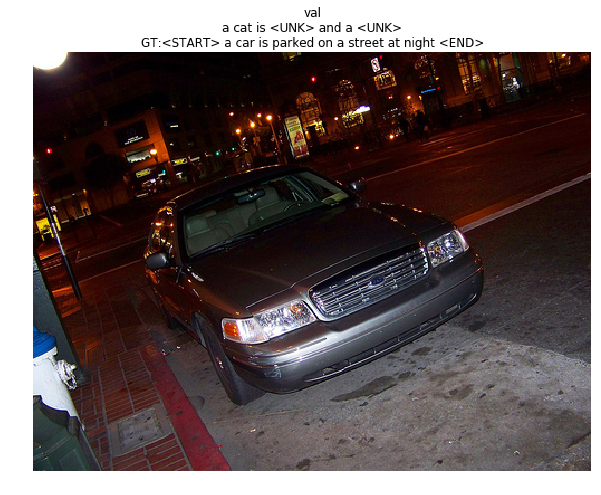

In [9]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Extra Credit: Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validation set that are better than random.

In addition to qualitatively evaluating your model by inspecting its results, you can also quantitatively evaluate your model using the BLEU unigram precision metric. We'll give you a small amount of extra credit if you can train a model that achieves a BLEU unigram score of >0.3. BLEU scores range from 0 to 1; the closer to 1, the better. Here's a reference to the [paper](http://www.aclweb.org/anthology/P02-1040.pdf) that introduces BLEU if you're interested in learning more about how it works.

Feel free to use PyTorch or TensorFlow for this section if you'd like to train faster on a GPU... though you can definitely get above 0.3 using your Numpy code. We're providing you the evaluation code that is compatible with the Numpy model as defined above... you should be able to adapt it for TensorFlow/PyTorch if you go that route.

In [ ]:
def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(med_data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

In [ ]:
t0 = time.time()

np.random.seed(231)

model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=100,
          wordvec_dim=32,
          dtype=np.float32,
        )

solver = CaptioningSolver(model, data,
           update_rule='adam',
           num_epochs=20,
           batch_size=32,
           optim_config={
             'learning_rate': 1e-3,
           },
           step_size=10,
           lr_decay=0.25,
           checkpoint_name='best_caption',
           verbose=True, print_every=200,
         )

solver.train()

print('{} seconds.'.format(time.time()-t0))

(Epoch 0 / 20) train loss: 81.639072; val loss: 77.614157
; with train bleu: 0.012463; val bleu: 0.011776
Saving checkpoint to "best_caption.pkl"

(Iteration 200 / 250080) loss: 48.231227
(Iteration 400 / 250080) loss: 43.643511
(Iteration 600 / 250080) loss: 41.975174
(Iteration 800 / 250080) loss: 36.898148
(Iteration 1000 / 250080) loss: 37.429036
(Iteration 1200 / 250080) loss: 36.902825
(Iteration 1400 / 250080) loss: 37.683227
(Iteration 1600 / 250080) loss: 31.871019
(Iteration 1800 / 250080) loss: 35.552607
(Iteration 2000 / 250080) loss: 33.358398
(Iteration 2200 / 250080) loss: 31.482419
(Iteration 2400 / 250080) loss: 30.503084
(Iteration 2600 / 250080) loss: 31.881107
(Iteration 2800 / 250080) loss: 30.040739
(Iteration 3000 / 250080) loss: 33.042531
(Iteration 3200 / 250080) loss: 34.340928
(Iteration 3400 / 250080) loss: 32.601875
(Iteration 3600 / 250080) loss: 31.365695
(Iteration 3800 / 250080) loss: 35.974107
(Iteration 4000 / 250080) loss: 31.149858
(Iteration 4200 /

(Iteration 36600 / 250080) loss: 28.855251
(Iteration 36800 / 250080) loss: 24.986731
(Iteration 37000 / 250080) loss: 24.369514
(Iteration 37200 / 250080) loss: 27.297858
(Iteration 37400 / 250080) loss: 30.361129
(Epoch 3 / 20) train loss: 25.831449; val loss: 26.741893
; with train bleu: 0.175985; val bleu: 0.176359

(Iteration 37600 / 250080) loss: 26.638713
(Iteration 37800 / 250080) loss: 27.164876
(Iteration 38000 / 250080) loss: 24.247943
(Iteration 38200 / 250080) loss: 24.582027
(Iteration 38400 / 250080) loss: 24.988549
(Iteration 38600 / 250080) loss: 29.725908
(Iteration 38800 / 250080) loss: 27.769773
(Iteration 39000 / 250080) loss: 27.424612
(Iteration 39200 / 250080) loss: 23.157077
(Iteration 39400 / 250080) loss: 28.899861
(Iteration 39600 / 250080) loss: 25.212227
(Iteration 39800 / 250080) loss: 26.444291
(Iteration 40000 / 250080) loss: 23.805079
(Iteration 40200 / 250080) loss: 27.156461
(Iteration 40400 / 250080) loss: 30.371781
(Iteration 40600 / 250080) loss: 

(Iteration 73200 / 250080) loss: 24.653160
(Iteration 73400 / 250080) loss: 25.647662
(Iteration 73600 / 250080) loss: 25.197306
(Iteration 73800 / 250080) loss: 23.539753
(Iteration 74000 / 250080) loss: 24.994282
(Iteration 74200 / 250080) loss: 26.396245
(Iteration 74400 / 250080) loss: 24.458218
(Iteration 74600 / 250080) loss: 25.666773
(Iteration 74800 / 250080) loss: 27.573042
(Iteration 75000 / 250080) loss: 23.801969
(Epoch 6 / 20) train loss: 26.153803; val loss: 26.165360
; with train bleu: 0.202391; val bleu: 0.201407
Saving checkpoint to "best_caption.pkl"

(Iteration 75200 / 250080) loss: 27.113140
(Iteration 75400 / 250080) loss: 23.998202
(Iteration 75600 / 250080) loss: 26.264331
(Iteration 75800 / 250080) loss: 27.267534
(Iteration 76000 / 250080) loss: 28.025293
(Iteration 76200 / 250080) loss: 25.296475
(Iteration 76400 / 250080) loss: 26.981553
(Iteration 76600 / 250080) loss: 25.216127
(Iteration 76800 / 250080) loss: 25.509432
(Iteration 77000 / 250080) loss: 30.

(Iteration 109600 / 250080) loss: 23.985560
(Iteration 109800 / 250080) loss: 26.080704
(Iteration 110000 / 250080) loss: 25.251745
(Iteration 110200 / 250080) loss: 22.905295
(Iteration 110400 / 250080) loss: 29.726638
(Iteration 110600 / 250080) loss: 23.049827
(Iteration 110800 / 250080) loss: 24.341309
(Iteration 111000 / 250080) loss: 26.633776
(Iteration 111200 / 250080) loss: 25.871249
(Iteration 111400 / 250080) loss: 25.634835
(Iteration 111600 / 250080) loss: 23.640366
(Iteration 111800 / 250080) loss: 25.387588
(Iteration 112000 / 250080) loss: 25.092509
(Iteration 112200 / 250080) loss: 24.815042
(Iteration 112400 / 250080) loss: 24.006419
(Epoch 9 / 20) train loss: 29.954256; val loss: 26.377124
; with train bleu: 0.197722; val bleu: 0.184804

(Iteration 112600 / 250080) loss: 25.746495
(Iteration 112800 / 250080) loss: 22.243182
(Iteration 113000 / 250080) loss: 26.453724
(Iteration 113200 / 250080) loss: 26.187321
(Iteration 113400 / 250080) loss: 26.484975
(Iteration 11

(Iteration 145400 / 250080) loss: 26.795639
(Iteration 145600 / 250080) loss: 23.196982
(Iteration 145800 / 250080) loss: 22.224930
(Iteration 146000 / 250080) loss: 26.512756
(Iteration 146200 / 250080) loss: 23.937018
(Iteration 146400 / 250080) loss: 24.549667
(Iteration 146600 / 250080) loss: 23.782595
(Iteration 146800 / 250080) loss: 25.799224
(Iteration 147000 / 250080) loss: 24.777959
(Iteration 147200 / 250080) loss: 27.725950
(Iteration 147400 / 250080) loss: 26.199992
(Iteration 147600 / 250080) loss: 21.811509
(Iteration 147800 / 250080) loss: 24.417982
(Iteration 148000 / 250080) loss: 25.054474
(Iteration 148200 / 250080) loss: 23.791974
(Iteration 148400 / 250080) loss: 21.578457
(Iteration 148600 / 250080) loss: 24.390066
(Iteration 148800 / 250080) loss: 21.270249
(Iteration 149000 / 250080) loss: 23.923155
(Iteration 149200 / 250080) loss: 26.202207
(Iteration 149400 / 250080) loss: 21.422848
(Iteration 149600 / 250080) loss: 23.802881
(Iteration 149800 / 250080) loss

(Iteration 181200 / 250080) loss: 25.149731
(Iteration 181400 / 250080) loss: 23.534354
(Iteration 181600 / 250080) loss: 25.299432
(Iteration 181800 / 250080) loss: 24.680108
(Iteration 182000 / 250080) loss: 29.597009
(Iteration 182200 / 250080) loss: 24.983898
(Iteration 182400 / 250080) loss: 23.783810
(Iteration 182600 / 250080) loss: 25.184076
(Iteration 182800 / 250080) loss: 23.204257
(Iteration 183000 / 250080) loss: 21.783125
(Iteration 183200 / 250080) loss: 27.791334
(Iteration 183400 / 250080) loss: 23.053237
(Iteration 183600 / 250080) loss: 24.100903
(Iteration 183800 / 250080) loss: 23.038591
(Iteration 184000 / 250080) loss: 25.095905
(Iteration 184200 / 250080) loss: 23.279426
(Iteration 184400 / 250080) loss: 28.106003
(Iteration 184600 / 250080) loss: 26.254950
(Iteration 184800 / 250080) loss: 24.686400
(Iteration 185000 / 250080) loss: 25.321788
(Iteration 185200 / 250080) loss: 25.223444
(Iteration 185400 / 250080) loss: 26.514362
(Iteration 185600 / 250080) loss

(Iteration 217000 / 250080) loss: 24.116073
(Iteration 217200 / 250080) loss: 25.208413
(Iteration 217400 / 250080) loss: 25.345814
(Iteration 217600 / 250080) loss: 25.631857
(Iteration 217800 / 250080) loss: 25.224420
(Iteration 218000 / 250080) loss: 24.612251
(Iteration 218200 / 250080) loss: 23.737882
(Iteration 218400 / 250080) loss: 22.138706
(Iteration 218600 / 250080) loss: 23.878718
(Iteration 218800 / 250080) loss: 22.908098
(Iteration 219000 / 250080) loss: 26.381394
(Iteration 219200 / 250080) loss: 24.462957
(Iteration 219400 / 250080) loss: 22.425193
(Iteration 219600 / 250080) loss: 24.858008
(Iteration 219800 / 250080) loss: 23.834142
(Iteration 220000 / 250080) loss: 26.075091
(Iteration 220200 / 250080) loss: 28.222723
(Iteration 220400 / 250080) loss: 23.448113
(Iteration 220600 / 250080) loss: 23.836525
(Iteration 220800 / 250080) loss: 22.385146
(Iteration 221000 / 250080) loss: 23.782517
(Iteration 221200 / 250080) loss: 26.891911
(Iteration 221400 / 250080) loss

In [13]:
t0 = time.time()

np.random.seed(231)

model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=100,
          wordvec_dim=50,
          dtype=np.float32,
        )

solver = CaptioningSolver(model, data,
           update_rule='adam',
           num_epochs=10,
           batch_size=32,
           optim_config={
             'learning_rate': 2e-3,
           },
           step_size=5,
           lr_decay=0.1,
           checkpoint_name='best_caption',
           verbose=True, print_every=200,
         )

solver.train()

print('{} seconds.'.format(time.time()-t0))

(Epoch 0 / 10) train loss: 80.012862; val loss: 76.680209
; with train bleu: 0.058371; val bleu: 0.053296
Saving checkpoint to "best_caption.pkl"

(Iteration 200 / 125040) loss: 43.436942
(Iteration 400 / 125040) loss: 38.424492
(Iteration 600 / 125040) loss: 35.214369
(Iteration 800 / 125040) loss: 32.190771
(Iteration 1000 / 125040) loss: 31.740942
(Iteration 1200 / 125040) loss: 33.969246
(Iteration 1400 / 125040) loss: 32.584998
(Iteration 1600 / 125040) loss: 34.696066
(Iteration 1800 / 125040) loss: 30.573749
(Iteration 2000 / 125040) loss: 29.837125
(Iteration 2200 / 125040) loss: 33.340198
(Iteration 2400 / 125040) loss: 28.756228
(Iteration 2600 / 125040) loss: 32.638681
(Iteration 2800 / 125040) loss: 29.842055
(Iteration 3000 / 125040) loss: 30.446769
(Iteration 3200 / 125040) loss: 27.773380
(Iteration 3400 / 125040) loss: 28.404265
(Iteration 3600 / 125040) loss: 29.559291
(Iteration 3800 / 125040) loss: 30.601944
(Iteration 4000 / 125040) loss: 26.471745
(Iteration 4200 /

(Iteration 36800 / 125040) loss: 24.746715
(Iteration 37000 / 125040) loss: 24.444846
(Iteration 37200 / 125040) loss: 25.873276
(Iteration 37400 / 125040) loss: 24.736809
(Epoch 3 / 10) train loss: 25.692630; val loss: 26.260524
; with train bleu: 0.188045; val bleu: 0.174139

(Iteration 37600 / 125040) loss: 26.858658
(Iteration 37800 / 125040) loss: 24.402247
(Iteration 38000 / 125040) loss: 27.339244
(Iteration 38200 / 125040) loss: 25.515867
(Iteration 38400 / 125040) loss: 26.022702
(Iteration 38600 / 125040) loss: 24.787224
(Iteration 38800 / 125040) loss: 25.071419
(Iteration 39000 / 125040) loss: 28.308703
(Iteration 39200 / 125040) loss: 27.389532
(Iteration 39400 / 125040) loss: 23.890151
(Iteration 39600 / 125040) loss: 26.701182
(Iteration 39800 / 125040) loss: 24.273974
(Iteration 40000 / 125040) loss: 26.038621
(Iteration 40200 / 125040) loss: 26.911432
(Iteration 40400 / 125040) loss: 26.720702
(Iteration 40600 / 125040) loss: 26.948169
(Iteration 40800 / 125040) loss: 

(Iteration 73200 / 125040) loss: 26.641632
(Iteration 73400 / 125040) loss: 26.268745
(Iteration 73600 / 125040) loss: 24.532607
(Iteration 73800 / 125040) loss: 22.613599
(Iteration 74000 / 125040) loss: 26.878279
(Iteration 74200 / 125040) loss: 26.730535
(Iteration 74400 / 125040) loss: 23.031559
(Iteration 74600 / 125040) loss: 24.193795
(Iteration 74800 / 125040) loss: 25.231585
(Iteration 75000 / 125040) loss: 23.754692
(Epoch 6 / 10) train loss: 24.517990; val loss: 25.892892
; with train bleu: 0.168091; val bleu: 0.178500

(Iteration 75200 / 125040) loss: 25.333703
(Iteration 75400 / 125040) loss: 25.455874
(Iteration 75600 / 125040) loss: 24.357208
(Iteration 75800 / 125040) loss: 23.544330
(Iteration 76000 / 125040) loss: 22.491199
(Iteration 76200 / 125040) loss: 28.521460
(Iteration 76400 / 125040) loss: 24.968787
(Iteration 76600 / 125040) loss: 26.205425
(Iteration 76800 / 125040) loss: 22.740732
(Iteration 77000 / 125040) loss: 25.269654
(Iteration 77200 / 125040) loss: 

(Iteration 109600 / 125040) loss: 23.914080
(Iteration 109800 / 125040) loss: 22.550178
(Iteration 110000 / 125040) loss: 23.439463
(Iteration 110200 / 125040) loss: 23.569550
(Iteration 110400 / 125040) loss: 23.006036
(Iteration 110600 / 125040) loss: 26.680390
(Iteration 110800 / 125040) loss: 26.876019
(Iteration 111000 / 125040) loss: 24.311806
(Iteration 111200 / 125040) loss: 25.265009
(Iteration 111400 / 125040) loss: 26.317826
(Iteration 111600 / 125040) loss: 25.935799
(Iteration 111800 / 125040) loss: 23.326484
(Iteration 112000 / 125040) loss: 28.418523
(Iteration 112200 / 125040) loss: 24.202631
(Iteration 112400 / 125040) loss: 26.726060
(Epoch 9 / 10) train loss: 23.957394; val loss: 25.586476
; with train bleu: 0.190019; val bleu: 0.197673

(Iteration 112600 / 125040) loss: 27.202802
(Iteration 112800 / 125040) loss: 25.633281
(Iteration 113000 / 125040) loss: 26.265427
(Iteration 113200 / 125040) loss: 24.929046
(Iteration 113400 / 125040) loss: 25.670636
(Iteration 11

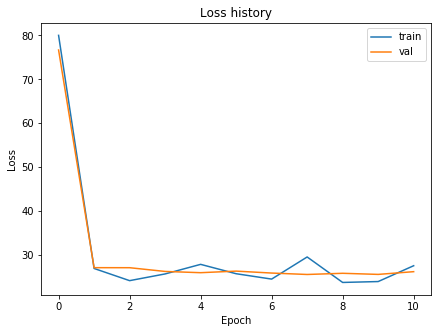

In [25]:
# Plot the training losses
plt.figure(figsize=(7,5))
plt.plot(solver.loss_history)
plt.plot(solver.val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['train', 'val'], loc='best')
plt.show()

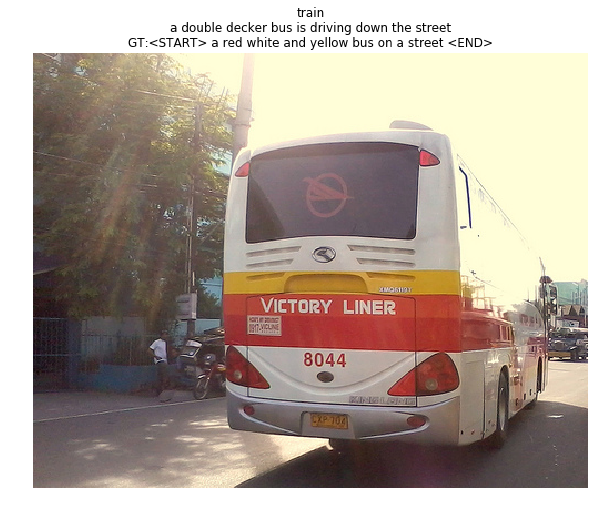

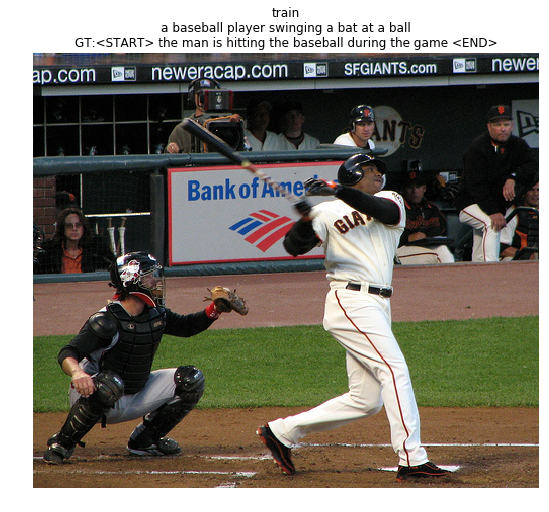

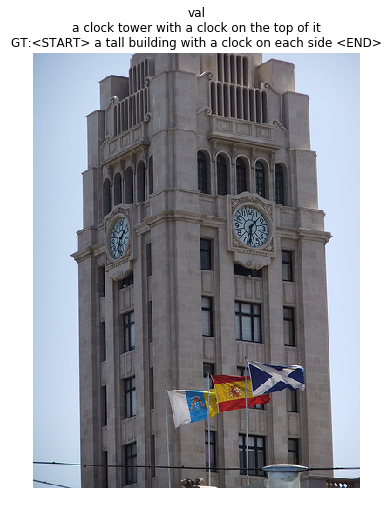

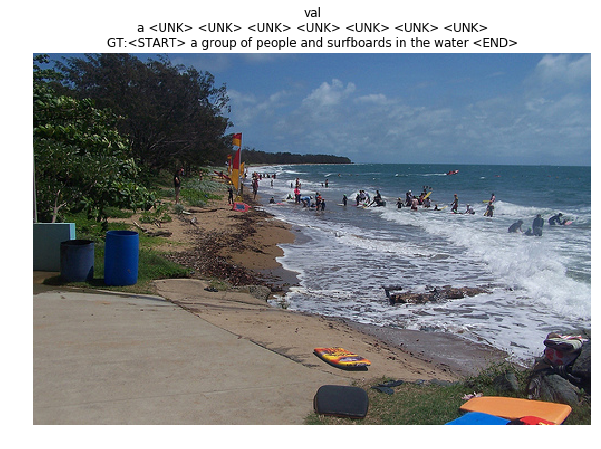

In [19]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

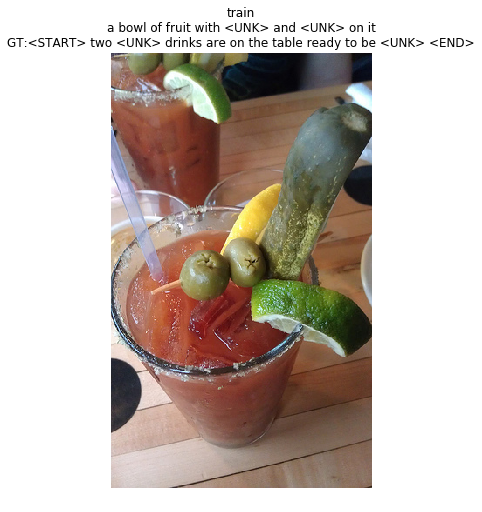

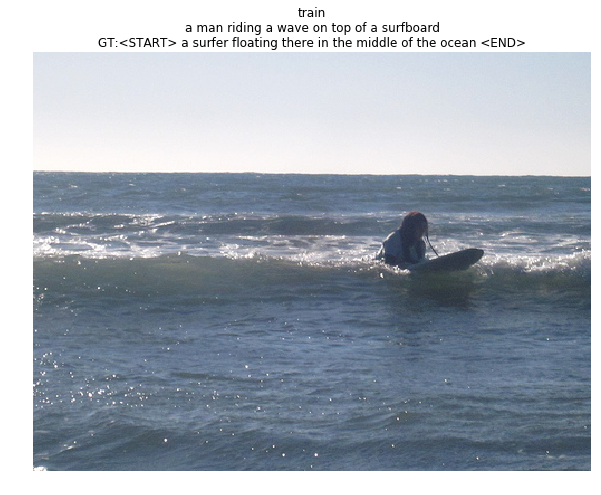

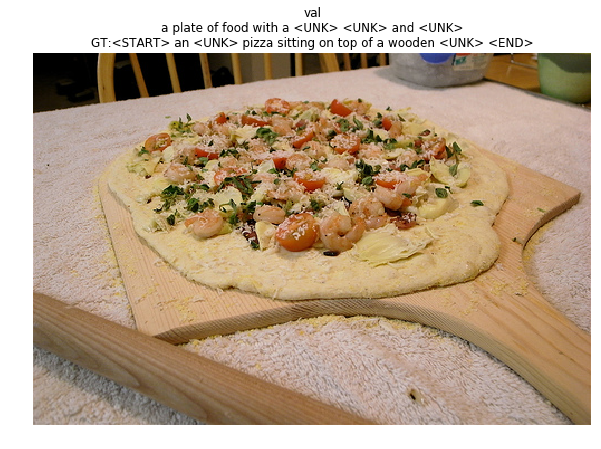

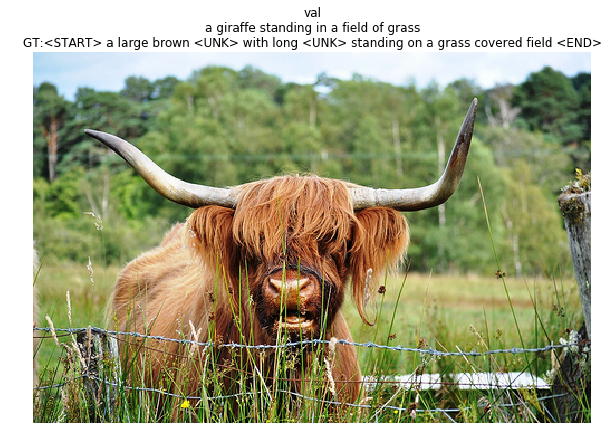

In [20]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()